# Assignment 3: Predicting Mapping Penalties with From-Scratch ANN
**Due:** June 5, 2025, 11:59 PM

**Author:** Tony Liang

**Student Number:** 20990204

In this assignment, a feed-forward artificial neural network (ANN) is implemented from scratch to predict the penalty score of a mapping between tasks and employees.

In this notebook we will:
1. Load the 100 mappings dataset  
2. Preprocess & encode into 110-dim vectors  
3. Define the ANN architectures and implement forward, backward, updates by hand  
5. Train via mini-batch SGD over grid of hyperparameters  
6. Produce the eight required comparison plots  
7. Export results for report submission  

## 1. Assignment Imports

In [17]:
try:
  if loaded:
    print("Data loaded!")
except:
  !git clone https://github.com/tonyzrl/ANN_Assignment
loaded = True

Data loaded!


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

# For reproducibility
np.random.seed(42)

# Task data: ID, Estimated Time, Difficulty, Deadline, Skill Required
tasks = [{"id": "T1", "estimated_time": 4, "difficulty": 3, "deadline": 8, "skill_required": "A"},
        {"id": "T2", "estimated_time": 6, "difficulty": 5, "deadline": 12, "skill_required": "B"},
        {"id": "T3", "estimated_time": 2, "difficulty": 2, "deadline": 6, "skill_required": "A"},
        {"id": "T4", "estimated_time": 5, "difficulty": 4, "deadline": 10, "skill_required": "C"},
        {"id": "T5", "estimated_time": 3, "difficulty": 1, "deadline": 7, "skill_required": "A"},
        {"id": "T6", "estimated_time": 8, "difficulty": 6, "deadline": 15, "skill_required": "B"},
        {"id": "T7", "estimated_time": 4, "difficulty": 3, "deadline": 9, "skill_required": "C"},
        {"id": "T8", "estimated_time": 7, "difficulty": 5, "deadline": 14, "skill_required": "B"},
        {"id": "T9", "estimated_time": 2, "difficulty": 2, "deadline": 5, "skill_required": "A"},
        {"id": "T10", "estimated_time": 6, "difficulty": 4, "deadline": 11, "skill_required": "C"},]

# Employee data: ID, Available hours, Skill level, Skills
employees = [{"id": "E1", "hours_avail": 10, "skill_level": 4, "skills": ["A", "C"]},
            {"id": "E2", "hours_avail": 12, "skill_level": 6, "skills": ["A", "B", "C"]},
            {"id": "E3", "hours_avail": 8, "skill_level": 3, "skills": ["A"]},
            {"id": "E4", "hours_avail": 15, "skill_level": 7, "skills": ["B", "C"]},
            {"id": "E5", "hours_avail": 9, "skill_level": 5, "skills": ["A", "C"]}]

## 2. Data Loading & Preprocessing

In [19]:
def one_hot_encode(skills):
    """
    One-hot encode a list of skills, e.g. ['A','C'] -> [1,0,1].
    """
    mapping = {'A': 0, 'B': 1, 'C': 2}
    vec = [0, 0, 0]
    for s in skills:
        vec[mapping[s]] = 1
    return vec

def construct_input_vector(mapping_row):
    """
    Given one row of the mapping CSV (task→employee assignments + penalty),
    plus the list of task & employee, construct the 110-dim vector.
    """
    input_vector = []
    # First 10 entries are employee assignments; last entry is penalty
    assignments = mapping_row[:10]

    for idx, emp_id in enumerate(assignments, start=1):
        task_id = f"T{idx}"
        # Find the task dict
        task = next(t for t in tasks if t["id"] == task_id)
        # Find the employee dict
        emp = next(e for e in employees if e["id"] == emp_id)

        # Task features: [time, difficulty, deadline] + one-hot(required skill)
        task_features = [
            task["estimated_time"],
            task["difficulty"],
            task["deadline"]
        ] + one_hot_encode(task["skill_required"])

        # Employee features: [hours_avail, skill_level] + one-hot(skills)
        emp_features = [
            emp["hours_avail"],
            emp["skill_level"],
        ] + one_hot_encode(emp["skills"])

        input_vector.extend(task_features + emp_features)

    return np.array(input_vector)

In [20]:
data = pd.read_csv('/content/ANN_Assignment/data/task_assignment_data.csv')
data = data.values

assignment_inputs = []
penalties = []

for row in data:
    assignment_inputs.append(construct_input_vector(row))
    penalties.append(row[-1])

X = np.vstack(assignment_inputs)             # (N, 110)
y = np.array(penalties).reshape(-1, 1) # (N,   1)

# Shuffle data and split 70/15/15
N = X.shape[0]
perm = np.random.permutation(N)
X, y = X[perm], y[perm]

X_train, y_train = X[:70], y[:70]
X_val,   y_val   = X[70:85], y[70:85]
X_test,  y_test  = X[85:],   y[85:]

# Transpose for Network
X_train, y_train = X_train.T, y_train.T   # (110, N_train), (1, N_train)
X_val, y_val = X_val.T, y_val.T     # (110, N_val),   (1, N_val)
X_test,  y_test  = X_test.T,  y_test.T    # (110, N_test),  (1, N_test)

## 3. Model Architecture

### Activation Functions

**ReLU**

The Rectified Linear Unit (ReLU) is a simple, yet highly effective activation function commonly used in Neural Networks. It is defined as:

**\begin{equation}
f(Z) = max(0, Z)
\end{equation}**

Where $Z$ is the input to the function. ReLU sets all negative values of $Z$ to zero, and leaves the positive values unchanged.

The derivative of the ReLU function can be computed as:

**\begin{equation}
f'(Z) = \begin{cases}
0, & \text{if } Z \leq 0 \
1, & \text{if } Z > 0
\end{cases}
\end{equation}**

---

**Sigmoid**

The Sigmoid function is a common activation function used in Neural Networks, particularly for binary classification problems. It is represented by the following formula:

**\begin{equation}
f(Z) = \frac{1}{1+e^{-Z}}
\end{equation}**

Where $Z$ is the input to the function. The Sigmoid function maps any real-valued number to a value between 0 and 1, which can be interpreted as a probability.

The derivative of the Sigmoid function can be computed as:

\begin{equation}
f'(Z) = f(Z)(1-f(Z))
\end{equation}

In [21]:
def sigmoid(Z):
    """
    Implement the Sigmoid function.
    """
    A = 1/(1+np.exp(-Z))
    cache = Z
    return A, cache

def sigmoid_deriv(dA, cache):
    """
    Implement the backward propagation for a single sigmoid unit.
    """
    Z = cache
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    return dZ

def relu(Z):
    """
    Implement the ReLU function.
    """
    A = np.maximum(0,Z)
    cache = Z
    return A, cache

def relu_deriv(dA, cache):
    """
    Implement the backward propagation for a single ReLU unit.

    """
    Z = cache
    dZ = np.array(dA, copy=True)
    # When z <= 0, dz is equal to 0 as well.
    dZ[Z <= 0] = 0

    return dZ

### Neural Network Class

In [22]:
class NeuralNetwork:
    def __init__(self, layer_dims=[110, 256, 1], learning_rate=1e-5, activation='relu'):
        """
        layer_dims: list of layer sizes, e.g [110,256,1] or [110,128,128,1]
        learning_rate: step size for gradient descent
        activation: 'relu' or 'sigmoid' for hidden layers
        """
        self.layer_dims    = layer_dims
        self.learning_rate = learning_rate

        # pick activation & its derivative
        if activation.lower() == 'relu':
            self.activation       = relu
            self.activation_deriv = relu_deriv
        else:
            self.activation       = sigmoid
            self.activation_deriv = sigmoid_deriv

        # number of layers (excluding input)
        self.L = len(layer_dims) - 1

        # initialise parameters for weights and biases
        for l in range(1, self.L + 1):
            n_in  = layer_dims[l-1]
            n_out = layer_dims[l]
            setattr(self, f'W{l}', np.random.randn(n_out, n_in) * 0.01)
            setattr(self, f'b{l}', np.zeros((n_out, 1)))

    def forward(self, X):
        """
        Performs a full forward pass.
        Returns:
          ZL: (1, m) predictions
          caches: list of ((A,W,b), Z) tuples
        """
        caches = []
        A = X

        # hidden layers
        for l in range(1, self.L):
            W = getattr(self, f'W{l}')
            b = getattr(self, f'b{l}')
            Z = W @ A + b
            # Cache (A_prev_for_next_layer, W, b) and Z
            caches.append(((A, W, b), Z))
            # Compute activation output
            A, _ = self.activation(Z)

        # output layer (linear)
        Wl = getattr(self, f'W{self.L}')
        bl = getattr(self, f'b{self.L}')
        ZL = Wl @ A + bl

        # Cache (A_prev_for_output_layer, Wl, bl) and ZL
        caches.append(((A, Wl, bl), ZL))
        return ZL, caches

    def back_layer(self, dZ, cache):
        """
        Backprop for a single layer given dZ = dL/dZ_l.
        cache: ((A_prev, W, b), Z)
        Returns dA_prev, dW, db.
        """
        (A_prev, W, b), Z = cache
        m = A_prev.shape[1]
        dW = (1/m) * (dZ @ A_prev.T)
        db = (1/m) * np.sum(dZ, axis=1, keepdims=True)
        dA_prev = W.T @ dZ
        return dA_prev, dW, db

    def backward(self, Y_hat, Y, caches):
        """
        Performs backprop over the whole network.
        Returns a dict of grads {dW1, db1, …, dWL, dbL}.
        """
        grads = {}
        m = Y.shape[1]

        # dZ for MSE loss at output: d/dZ [ (1/m) ∑ (ZL - Y)^2 ] = 2*(ZL - Y)/m
        dZ = 2 * (Y_hat - Y) / m

        # **Output layer** gradients (Layer L)
        cacheL = caches[-1] # This is the cache for the last layer (output)
        dA_prev, dWl, dbl = self.back_layer(dZ, cacheL)
        grads[f'dW{self.L}'] = dWl
        grads[f'db{self.L}'] = dbl

        # **Hidden layers** (L-1 .. 1)
        # dA here is the gradient of the cost with respect to the activation output of layer L-1
        dA = dA_prev
        for l in reversed(range(1, self.L)): # Loop through hidden layers backwards
            # cache for the current layer 'l' from forward pass
            # This cache contains ((A_prev_to_layer_l, W_l, b_l), Z_l)
            cache_l = caches[l-1]

            # Get Z_l from cache
            Z = cache_l[1]

            # Convert dA_l (gradient wrt A_l) to dZ_l (gradient wrt Z_l)
            # A_l is the activation output of layer l.
            # dA was computed as the backprop output from layer l+1,
            # so it's the gradient wrt A_l.
            dZ = self.activation_deriv(dA, Z)

            # Get A_prev_to_layer_l from cache
            A_prev = cache_l[0][0]

            # Backprop through the linear part of layer l
            dA, dW, db = self.back_layer(dZ, ( (A_prev, cache_l[0][1], cache_l[0][2]), Z) ) # Pass the correct A_prev to back_layer
            grads[f'dW{l}'] = dW
            grads[f'db{l}'] = db
            # dA from back_layer is dA_prev for layer l, which is dA for layer l-1 for next iteration
        return grads

    def update_parameters(self, grads):
        """
        Applies gradient descent: W -= lr * dW,  b -= lr * db.
        """
        for l in range(1, self.L+1):
            W = getattr(self, f'W{l}')
            b = getattr(self, f'b{l}')
            dW = grads[f'dW{l}']
            db = grads[f'db{l}']
            setattr(self, f'W{l}', W - self.learning_rate * dW)
            setattr(self, f'b{l}', b - self.learning_rate * db)

    def compute_cost(self, Y_hat, Y):
        """
        Mean Squared Error:
          (1/m) * sum((Y_hat - Y)^2)
        Y_hat, Y both shape (1, m)
        """
        return np.mean((Y_hat - Y)**2)

## 4. Training Loop

In [23]:
def training(layer_dims):
    # ——— Hyper-parameters ———
    learning_rates = [0.01, 0.001, 0.0001]
    batch_sizes    = [8, 16, 32]
    activations    = ['sigmoid', 'relu']
    epochs         = 100

    results = []  # <— move this outside the loops!

    # ——— Training Loop ———
    for lr in learning_rates:
        for batch_size in batch_sizes:
            for activation in activations:
                # 1) Instantiate a fresh model for this combo
                model = NeuralNetwork(layer_dims,
                                      learning_rate=lr,
                                      activation=activation)
                train_losses = []
                val_losses   = []
                epoch_times  = []

                # 2) Epoch loop
                for epoch in range(epochs):
                    t0 = time.time()

                    # a) Shuffle training set
                    perm = np.random.permutation(X_train.shape[1])
                    X_sh = X_train[:, perm]
                    y_sh = y_train[:, perm]

                    # b) Mini-batch gradient descent
                    for i in range(0, X_sh.shape[1], batch_size):
                        xb = X_sh[:, i:i+batch_size]
                        yb = y_sh[:, i:i+batch_size]

                        # forward → backward → update
                        y_hat, caches = model.forward(xb)
                        grads         = model.backward(y_hat, yb, caches)
                        model.update_parameters(grads)

                    # c) Record epoch-level train & val loss
                    y_hat_tr, _ = model.forward(X_train)
                    train_losses.append(model.compute_cost(y_hat_tr, y_train))

                    y_hat_val, _ = model.forward(X_val)
                    val_losses.append(model.compute_cost(y_hat_val, y_val))

                    epoch_times.append(time.time() - t0)

                # 3) Final test evaluation
                y_hat_test, _ = model.forward(X_test)
                test_loss = model.compute_cost(y_hat_test, y_test)

                # 4) Store this run’s results
                results.append({
                    'layer_dims':   layer_dims,
                    'learning_rate': lr,
                    'batch_size':   batch_size,
                    'activation':   activation,
                    'train_losses': train_losses,
                    'val_losses':   val_losses,
                    'epoch_times':  epoch_times,
                    'test_loss':    test_loss
                })
    return results

modelA = [110, 256, 1]
modelB = [110, 128, 128, 1]

resultsA = training(modelA)
resultsB = training(modelB)

# Compare test losses:
print("Model A best test loss:", min(r['test_loss'] for r in resultsA))
print("Model B best test loss:", min(r['test_loss'] for r in resultsB))

Model A best test loss: 2.1761366482794355
Model B best test loss: 2.1766466964190783


## 5. Evaluation and Plots

### Epoch vs Loss (Train & Val)


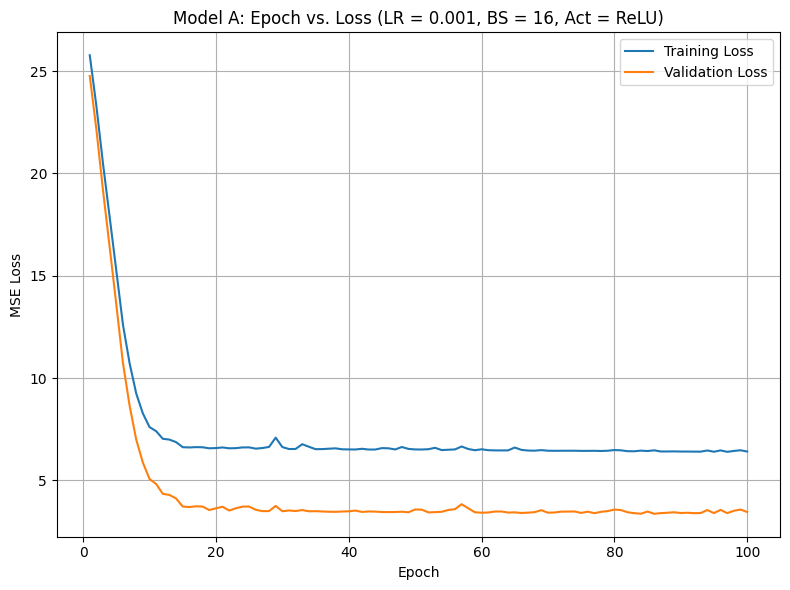

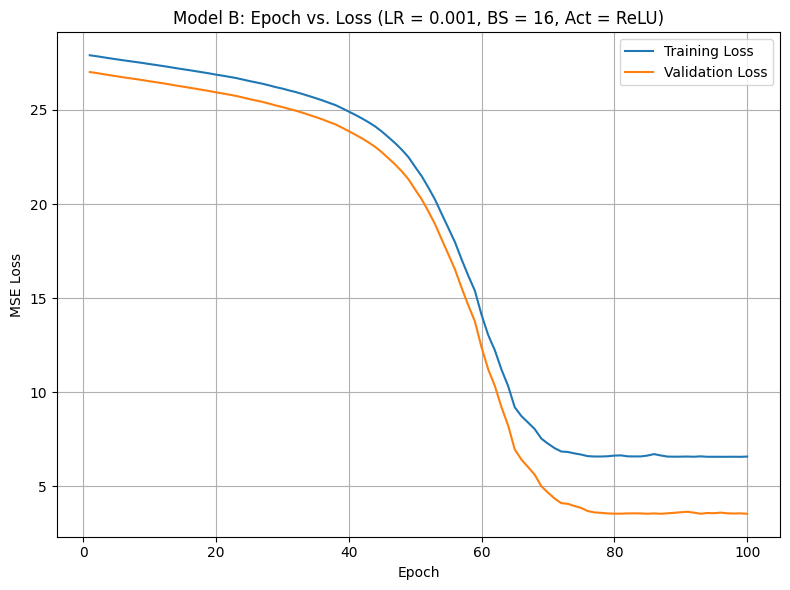

In [24]:
for run in resultsA:
    if (run['learning_rate'] == 0.001
        and run['batch_size']   == 16
        and run['activation']   == 'relu'):

        title = "Model A: Epoch vs. Loss (LR = 0.001, BS = 16, Act = ReLU)"

        # plot
        train, val = run['train_losses'], run['val_losses']
        epochs = range(1, len(train)+1)
        plt.figure(figsize=(8,6))
        plt.plot(epochs, train, label='Training Loss')
        plt.plot(epochs, val,   label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('MSE Loss')
        plt.title(title)
        plt.legend()
        plt.grid(True)

        # save & close
        plt.tight_layout()
        plt.savefig('modelA_Epoch_vs_Loss.png')

for run in resultsB:
    if (run['learning_rate'] == 0.001
        and run['batch_size']   == 16
        and run['activation']   == 'relu'):

        title = "Model B: Epoch vs. Loss (LR = 0.001, BS = 16, Act = ReLU)"

        # plot
        train, val = run['train_losses'], run['val_losses']
        epochs = range(1, len(train)+1)
        plt.figure(figsize=(8,6))
        plt.plot(epochs, train, label='Training Loss')
        plt.plot(epochs, val,   label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('MSE Loss')
        plt.title(title)
        plt.legend()
        plt.grid(True)

        # save & close
        plt.tight_layout()
        plt.savefig('modelB_Epoch_vs_Loss.png')

### Learning Rate vs Loss (Test)

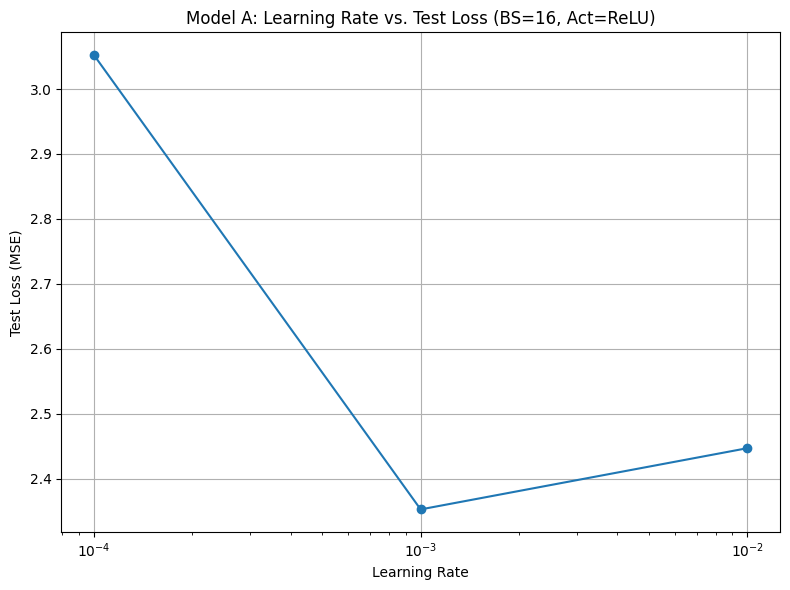

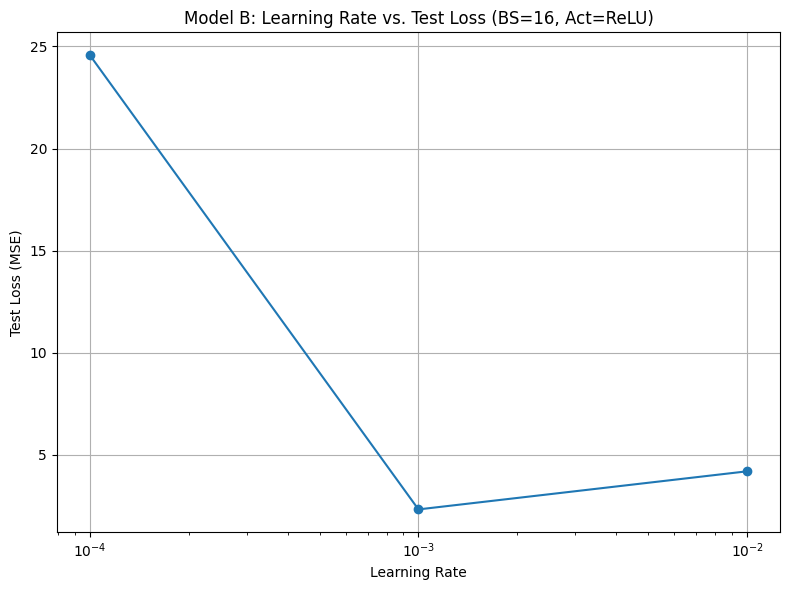

In [25]:
# === Model A: Learning Rate vs. Test Loss (BS=16, Act=ReLU) ===
lrs_A   = []
lossesA = []

for run in resultsA:
    if run['batch_size'] == 16 and run['activation'] == 'relu':
        lrs_A.append(run['learning_rate'])
        lossesA.append(run['test_loss'])

# Sort by learning rate
pairsA = sorted(zip(lrs_A, lossesA))
lrs_A, lossesA = zip(*pairsA)

plt.figure(figsize=(8,6))
plt.plot(lrs_A, lossesA, marker='o')
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Test Loss (MSE)')
plt.title('Model A: Learning Rate vs. Test Loss (BS=16, Act = ReLU)')
plt.grid(True)
plt.tight_layout()
plt.savefig('modelA_LR_vs_TestLoss.png')

# === Model B: Learning Rate vs. Test Loss (BS=16, Act=ReLU) ===
lrs_B   = []
lossesB = []

for run in resultsB:
    if run['batch_size'] == 16 and run['activation'] == 'relu':
        lrs_B.append(run['learning_rate'])
        lossesB.append(run['test_loss'])

# Sort by learning rate
pairsB = sorted(zip(lrs_B, lossesB))
lrs_B, lossesB = zip(*pairsB)

plt.figure(figsize=(8,6))
plt.plot(lrs_B, lossesB, marker='o')
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Test Loss (MSE)')
plt.title('Model B: Learning Rate vs. Test Loss (BS=16, Act = ReLU)')
plt.grid(True)
plt.tight_layout()
plt.savefig('modelB_LR_vs_TestLoss.png')

### Activation Function vs Loss (Train & Val)

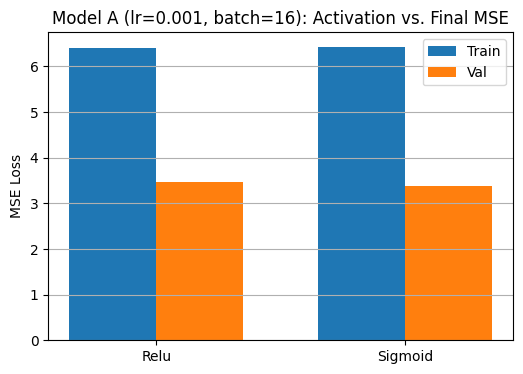

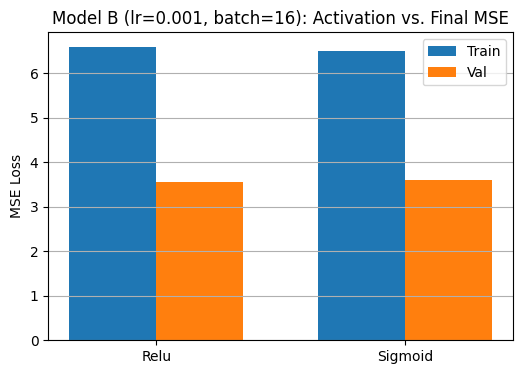

In [31]:
# === Model A: Activation vs. Final Train & Val Loss (BS=16, LR=0.001) ===
activations       = ['relu', 'sigmoid']
train_losses_actA = []
val_losses_actA   = []

for act in activations:
    runA = next(r for r in resultsA
                if r['activation']==act
                and r['learning_rate']==0.001
                and r['batch_size']==16)
    train_losses_actA.append(runA['train_losses'][-1])
    val_losses_actA.append(  runA['val_losses'][-1])

x     = np.arange(len(activations))
width = 0.35

plt.figure(figsize=(6,4))
plt.bar(x - width/2, train_losses_actA, width, label='Train')
plt.bar(x + width/2, val_losses_actA,   width, label='Val')
plt.xticks(x, [a.capitalize() for a in activations])
plt.title("Model A: Activation vs. Loss (LR = 0.001, BS = 16)")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(axis='y')
plt.savefig('modelA_AF_vs_Loss.png')

# === Model B: Activation vs. Final Train & Val Loss (BS=16, LR=0.001) ===
activations       = ['relu', 'sigmoid']
train_losses_actB = []
val_losses_actB   = []

for act in activations:
    runB = next(r for r in resultsB
                if r['activation']==act
                and r['learning_rate']==0.001
                and r['batch_size']==16)
    train_losses_actB.append(runB['train_losses'][-1])
    val_losses_actB.append(  runB['val_losses'][-1])

x     = np.arange(len(activations))
width = 0.35

plt.figure(figsize=(6,4))
plt.bar(x - width/2, train_losses_actB, width, label='Train')
plt.bar(x + width/2, val_losses_actB,   width, label='Val')
plt.xticks(x, [a.capitalize() for a in activations])
plt.title("Model A: Activation vs. Loss (LR = 0.001, BS = 16)")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(axis='y')
plt.savefig('modelB_AF_vs_Loss.png')

### Batch Size vs Epoch Time

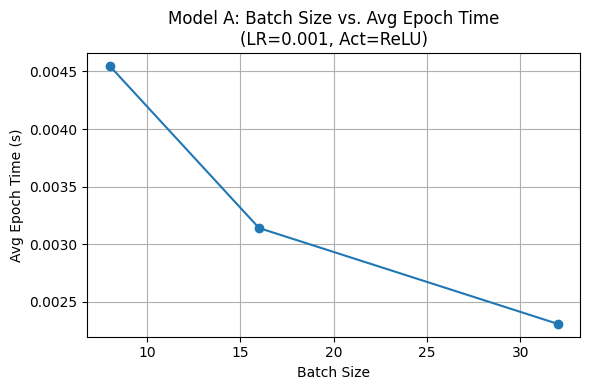

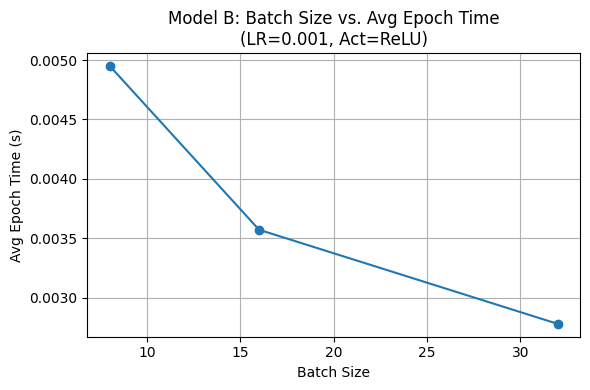

In [27]:
# === Model A: Batch Size vs. Avg Epoch Time (LR=0.001, Act=ReLU) ===
batch_sizes = [8, 16, 32]
avg_timesA  = []

for bs in batch_sizes:
    run = next(r for r in resultsA
               if r['batch_size']==bs
               and r['learning_rate']==0.001
               and r['activation']=='relu')
    avg_timesA.append(np.mean(run['epoch_times']))

plt.figure(figsize=(6,4))
plt.plot(batch_sizes, avg_timesA, marker='o')
plt.xlabel('Batch Size')
plt.ylabel('Avg Epoch Time (s)')
plt.title('Model A: Batch Size vs. Avg Epoch Time\n(LR = 0.001, Act = ReLU)')
plt.grid(True)
plt.tight_layout()
plt.savefig('modelA_BS_vs_EpochTime.png')

# === Model B: Batch Size vs. Avg Epoch Time (LR=0.001, Act=ReLU) ===
batch_sizes = [8, 16, 32]
avg_timesB  = []

for bs in batch_sizes:
    run = next(r for r in resultsB
               if r['batch_size']==bs
               and r['learning_rate']==0.001
               and r['activation']=='relu')
    avg_timesB.append(np.mean(run['epoch_times']))

plt.figure(figsize=(6,4))
plt.plot(batch_sizes, avg_timesB, marker='o')
plt.xlabel('Batch Size')
plt.ylabel('Avg Epoch Time (s)')
plt.title('Model B: Batch Size vs. Avg Epoch Time\n(LR = 0.001, Act = ReLU)')
plt.grid(True)
plt.tight_layout()
plt.savefig('modelB_BS_vs_EpochTime.png')

In [32]:
from google.colab import files

# after saving your figure...
files.download('modelA_Epoch_vs_Loss.png')
files.download('modelB_Epoch_vs_Loss.png')

files.download('modelA_LR_vs_TestLoss.png')
files.download('modelB_LR_vs_TestLoss.png')

files.download('modelA_AF_vs_Loss.png')
files.download('modelB_AF_vs_Loss.png')

files.download('modelA_BS_vs_EpochTime.png')
files.download('modelB_BS_vs_EpochTime.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>